In [2]:
import re
import pandas as pd
#from sklearn.model_selection import train_test_split

# Load the CSV file into a DataFrame
short = pd.read_csv('intermediate-charge-density22.csv')
short['Class'] = 1

pos = short[
    (short['Sequence'].str.len() > 6) &
    (short['Sequence'].str.len() < 40)
]
pos


,Sequence,Class
0,FIKHFIHRF,1
1,LIKHILHRL,1
2,LQLLKQLLKLLKQF,1
3,IKQLLHFFQRF,1
4,LKQFVHFIHRF,1
...,...,...
3045,GLLSVLKGVLKTAGKHIFKNVGGSLLDQAKCKISGEC,1
3046,GRDYRTSLTIVQKLKKMVD,1
3047,KRFKQDGGWSHWSPWSS,1
3048,PDEDAINNALNKVCSTGRRQRSICKQLLKK,1


In [4]:
import re
import pandas as pd
#from sklearn.model_selection import train_test_split

# Load the CSV file into a DataFrame
short = pd.read_csv('neg-intermediate-charge-density22.csv')
short['Class'] = 0
neg = short[
    (short['Sequence'].str.len() > 6) &
    (short['Sequence'].str.len() < 40)
]
neg
# Display the result

neg = neg.sample(n=min(3050, len(neg)), random_state=40)
neg

,Sequence,Class
12093,IDVEKKKQKDVKFVHRMPISFL,0
1891,AKVDVPKRYIGWRAYVIVVRD,0
13051,CAIRGSALLVIVCTLIGISCYRMRELSK,0
24727,EQVLLLRLFGPFATACELLHNAKRSPRFR,0
23507,HYNKYLTRKRRLEIAHTLTLTERQI,0
...,...,...
6414,GQLANAVGAGIKSMGETLRGFLRQKSAKR,0
8572,YNVHKHTDGKC,0
21720,KTLCYSKSEQMLRYSIKLLLYYLKYQIVPI,0
18632,QTLKLICKECGYTIHREGIRLRKLEIVG,0


In [6]:
concatenated_df = pd.concat([pos,neg], ignore_index=True)
concatenated_df = concatenated_df.drop_duplicates(subset='Sequence', keep=False)
concatenated_df

,Sequence,Class
0,FIKHFIHRF,1
1,LIKHILHRL,1
2,LQLLKQLLKLLKQF,1
3,IKQLLHFFQRF,1
4,LKQFVHFIHRF,1
...,...,...
6095,GQLANAVGAGIKSMGETLRGFLRQKSAKR,0
6096,YNVHKHTDGKC,0
6097,KTLCYSKSEQMLRYSIKLLLYYLKYQIVPI,0
6098,QTLKLICKECGYTIHREGIRLRKLEIVG,0


In [10]:
import re
# Clean comma-separated sequences (take the first part)
concatenated_df['Sequence'] = concatenated_df['Sequence'].str.split(',').str[0]

# Remove spaces
concatenated_df['Sequence'] = concatenated_df['Sequence'].str.replace(' ', '', regex=False)

# Remove invalid amino acids
concatenated_df['Sequence'] = concatenated_df['Sequence'].apply(lambda x: re.sub(r'[^ACDEFGHIKLMNPQRSTVWY]', '', x))

#from sklearn.model_selection import train_test_split

# Remove sequences with issues
concatenated_df =concatenated_df[~concatenated_df['Sequence'].str.contains('[, ZBOUXJ ]')]
# Optional: show progress bar
concatenated_df

,Sequence,Class,PDB_File
0,FIKHFIHRF,1,id/peptide_0.pdb
1,LIKHILHRL,1,id/peptide_1.pdb
2,LQLLKQLLKLLKQF,1,id/peptide_2.pdb
3,IKQLLHFFQRF,1,id/peptide_3.pdb
4,LKQFVHFIHRF,1,id/peptide_4.pdb
...,...,...,...
6093,GQLANAVGAGIKSMGETLRGFLRQKSAKR,0,id/peptide_6093.pdb
6094,YNVHKHTDGKC,0,id/peptide_6094.pdb
6095,KTLCYSKSEQMLRYSIKLLLYYLKYQIVPI,0,id/peptide_6095.pdb
6096,QTLKLICKECGYTIHREGIRLRKLEIVG,0,id/peptide_6096.pdb


In [11]:
concatenated_df = concatenated_df.reset_index(drop=True)
concatenated_df

,Sequence,Class,PDB_File
0,FIKHFIHRF,1,id/peptide_0.pdb
1,LIKHILHRL,1,id/peptide_1.pdb
2,LQLLKQLLKLLKQF,1,id/peptide_2.pdb
3,IKQLLHFFQRF,1,id/peptide_3.pdb
4,LKQFVHFIHRF,1,id/peptide_4.pdb
...,...,...,...
6093,GQLANAVGAGIKSMGETLRGFLRQKSAKR,0,id/peptide_6093.pdb
6094,YNVHKHTDGKC,0,id/peptide_6094.pdb
6095,KTLCYSKSEQMLRYSIKLLLYYLKYQIVPI,0,id/peptide_6095.pdb
6096,QTLKLICKECGYTIHREGIRLRKLEIVG,0,id/peptide_6096.pdb


In [ ]:
import requests
import os
import time
import pandas as pd

# Configuration
OUTPUT_DIR = "id/"
SLEEP_TIME = 5  # Seconds between requests
MAX_RETRIES = 3  # Retry attempts for failed requests
START_INDEX = 0  # <-- Change here to resume

# Create the output directory
os.makedirs(OUTPUT_DIR, exist_ok=True)

def get_pdb_from_sequence(seq, out_file_path):
    """Get PDB structure from ESM Atlas API for a given amino acid sequence"""
    url = "https://api.esmatlas.com/foldSequence/v1/pdb/"
    headers = {
        "Content-Type": "text/plain"
    }

    # Sanitize sequence
    clean_seq = ''.join(filter(str.isalpha, seq)).upper()

    for attempt in range(MAX_RETRIES):
        try:
            response = requests.post(url, data=clean_seq, headers=headers, timeout=30)
            if response.ok:
                with open(out_file_path, "w") as f:
                    f.write(response.text)
                return True
            else:
                print(f"Attempt {attempt + 1} failed for {clean_seq[:10]}... "
                      f"Status: {response.status_code}, Response: {response.text[:100]}")
                if response.status_code == 429:
                    time.sleep(SLEEP_TIME * (attempt + 2))  # Exponential backoff
        except Exception as e:
            print(f"Attempt {attempt + 1} error: {str(e)}")
            time.sleep(SLEEP_TIME)

    return False

# Initialize PDB_File column if missing
if 'PDB_File' not in concatenated_df.columns:
    concatenated_df['PDB_File'] = [None] * len(concatenated_df)

# Process each sequence from START_INDEX onward
for idx in range(START_INDEX, len(concatenated_df)):
    seq = concatenated_df.at[idx, 'Sequence']
    filename = f"peptide_{idx}.pdb"
    file_path = os.path.join(OUTPUT_DIR, filename)

    print(f"Processing sequence {idx + 1}/{len(concatenated_df)}: {seq[:15]}...")

    # Skip if already exists (optional)
    if os.path.exists(file_path):
        print(f"Already exists: {file_path}")
        concatenated_df.at[idx, 'PDB_File'] = file_path
        continue

    success = get_pdb_from_sequence(seq, file_path)
    if success:
        print(f"Successfully saved: {file_path}")
        concatenated_df.at[idx, 'PDB_File'] = file_path
    else:
        print(f"Failed to get PDB for index {idx}")
        concatenated_df.at[idx, 'PDB_File'] = None

    time.sleep(SLEEP_TIME)




In [ ]:
import requests
import os
import time
import pandas as pd


# Configuration
OUTPUT_DIR = "id/"
SLEEP_TIME = 5        # Seconds between requests
MAX_RETRIES = 3       # Retry attempts for failed requests
START_INDEX = 1450       # <-- Change this to resume from a specific index

# Create the output directory if it doesn't exist
os.makedirs(OUTPUT_DIR, exist_ok=True)

def get_pdb_from_sequence(seq, out_file_path):
    """Get PDB structure from ESM Atlas API for a given amino acid sequence"""
    url = "https://api.esmatlas.com/foldSequence/v1/pdb/"
    headers = {
        "Content-Type": "text/plain"
    }

    # Sanitize sequence
    clean_seq = ''.join(filter(str.isalpha, seq)).upper()

    for attempt in range(MAX_RETRIES):
        try:
            response = requests.post(url, data=clean_seq, headers=headers, timeout=30)
            if response.ok:
                with open(out_file_path, "w") as f:
                    f.write(response.text)
                return True
            else:
                print(f"Attempt {attempt + 1} failed for {clean_seq[:10]}... "
                      f"Status: {response.status_code}, Response: {response.text[:100]}")
                if response.status_code == 429:
                    time.sleep(SLEEP_TIME * (attempt + 2))  # Exponential backoff
        except Exception as e:
            print(f"Attempt {attempt + 1} error: {str(e)}")
            time.sleep(SLEEP_TIME)

    return False

# Initialize PDB_File column if missing
if 'PDB_File' not in concatenated_df.columns:
    concatenated_df['PDB_File'] = [None] * len(concatenated_df)

# Process each sequence from START_INDEX onward
for pos in range(START_INDEX, len(concatenated_df)):
    seq = concatenated_df.iloc[pos]['Sequence']
    filename = f"peptide_{pos}.pdb"
    file_path = os.path.join(OUTPUT_DIR, filename)

    print(f"Processing sequence {pos + 1}/{len(concatenated_df)}: {seq[:15]}...")

    # Skip if file already exists
    if os.path.exists(file_path):
        print(f"Already exists: {file_path}")
        concatenated_df.iloc[pos, concatenated_df.columns.get_loc('PDB_File')] = file_path
        continue

    # Try to get PDB from sequence
    success = get_pdb_from_sequence(seq, file_path)
    if success:
        print(f"✅ Successfully saved: {file_path}")
        concatenated_df.iloc[pos, concatenated_df.columns.get_loc('PDB_File')] = file_path
    else:
        print(f"❌ Failed to get PDB for index {pos}")
        concatenated_df.iloc[pos, concatenated_df.columns.get_loc('PDB_File')] = None

    time.sleep(SLEEP_TIME)



In [9]:
import os

OUTPUT_DIR = "id/"
existing_files = os.listdir(OUTPUT_DIR)

for file in existing_files:
    if file.endswith(".pdb") and file.startswith("peptide_"):
        try:
            idx = int(file.replace("peptide_", "").replace(".pdb", ""))
            file_path = os.path.join(OUTPUT_DIR, file)
            if 0 <= idx < len(concatenated_df):
                concatenated_df.at[idx, 'PDB_File'] = file_path
        except ValueError:
            continue  # In case there's a filename that doesn't match the pattern


concatenated_df.to_csv("peptides_with_pdb_paths_fixed.csv", index=False)
print("✅ PDB_File column updated from existing files.")
concatenated_df

✅ PDB_File column updated from existing files.


,Sequence,Class,PDB_File
0,FIKHFIHRF,1,id/peptide_0.pdb
1,LIKHILHRL,1,id/peptide_1.pdb
2,LQLLKQLLKLLKQF,1,id/peptide_2.pdb
3,IKQLLHFFQRF,1,id/peptide_3.pdb
4,LKQFVHFIHRF,1,id/peptide_4.pdb
...,...,...,...
6093,GQLANAVGAGIKSMGETLRGFLRQKSAKR,0,id/peptide_6093.pdb
6094,YNVHKHTDGKC,0,id/peptide_6094.pdb
6095,KTLCYSKSEQMLRYSIKLLLYYLKYQIVPI,0,id/peptide_6095.pdb
6096,QTLKLICKECGYTIHREGIRLRKLEIVG,0,id/peptide_6096.pdb


In [12]:
from Bio.PDB import PDBParser, DSSP
import pandas as pd
import numpy as np
import os

# Path to folder containing PDB files
pdb_directory = "id/" 

# Initialize DSSP feature columns
dssp_columns = ['Mean_RSA', 'Mean_Phi', 'Mean_Psi']
for col in dssp_columns:
    concatenated_df[col] = np.nan

parser = PDBParser(QUIET=True)

# Loop to calculate RSA, Phi, Psi features
for idx in concatenated_df.index:
    pdb_filename = f"peptide_{idx}.pdb"
    pdb_path = os.path.join(pdb_directory, pdb_filename)

    if not os.path.exists(pdb_path):
        print(f"File not found: {pdb_path}")
        continue

    try:
        structure = parser.get_structure(f"pep_{idx}", pdb_path)
        model = structure[0]
        dssp = DSSP(model, pdb_path)

        rsa_list = []
        phi_list = []
        psi_list = []

        for res in dssp:
            rsa = res[3]
            phi = res[4]
            psi = res[5]

            rsa_list.append(rsa)
            phi_list.append(phi)
            psi_list.append(psi)

        # Compute means
        concatenated_df.at[idx, 'Mean_RSA'] = np.mean(rsa_list) if rsa_list else np.nan
        concatenated_df.at[idx, 'Mean_Phi'] = np.mean(phi_list) if phi_list else np.nan
        concatenated_df.at[idx, 'Mean_Psi'] = np.mean(psi_list) if psi_list else np.nan

    except Exception as e:
        print(f"Error processing index {idx} - file: {pdb_path}: {e}")


In [13]:
from Bio.PDB import PDBParser, DSSP
import os

# Columns to store DSSP secondary structure percentages
helices = []
sheets = []
coils = []

parser = PDBParser()

for idx in concatenated_df.index:
    pdb_file = f"id//peptide_{idx}.pdb"
    try:
        structure = parser.get_structure(f"pep_{idx}", pdb_file)
        model = structure[0]
        dssp = DSSP(model, pdb_file)
        
        ss_list = [dssp[key][2] for key in dssp.keys()]
        total = len(ss_list)
        
        helix_count = sum(s in "HGI" for s in ss_list)
        sheet_count = sum(s in "BE" for s in ss_list)
        coil_count  = sum(s in "ST " for s in ss_list)  # includes turn, bend, and loops
        
        helices.append(helix_count / total * 100)
        sheets.append(sheet_count / total * 100)
        coils.append(coil_count / total * 100)
    except Exception as e:
        print(f"Failed to process {pdb_file}: {e}")
        helices.append(None)
        sheets.append(None)
        coils.append(None)

# Add DSSP % columns to DataFrame
concatenated_df['%Helix'] = helices
concatenated_df['%Sheet'] = sheets
concatenated_df['%Coil'] = coils


In [45]:
import mdtraj as md
import pandas as pd
import numpy as np
import os

# Folder containing your PDBs
pdb_folder = 'id/'

# Initialize columns
concatenated_df['RoG'] = np.nan
concatenated_df['SASA'] = np.nan
concatenated_df['Compactness'] = np.nan

# Loop through each peptide
for idx in concatenated_df.index:
    pdb_path = os.path.join(pdb_folder, f"peptide_{idx}.pdb")

    if not os.path.exists(pdb_path):
        print(f"Missing: {pdb_path}")
        continue

    try:
        traj = md.load(pdb_path)
        
        # Radius of Gyration (RoG)
        rog = md.compute_rg(traj)[0]
        concatenated_df.at[idx, 'RoG'] = rog

        # Solvent Accessible Surface Area (SASA)
        sasa = md.shrake_rupley(traj)[0].sum()
        concatenated_df.at[idx, 'SASA'] = sasa

        # Compactness = Mass / SASA (or optionally 1/SASA per atom)
        n_atoms = traj.n_atoms
        compactness = n_atoms / sasa if sasa > 0 else np.nan
        concatenated_df.at[idx, 'Compactness'] = compactness

    except Exception as e:
        print(f"Error at index {idx}: {e}")


In [46]:
cleaned_df = concatenated_df
cleaned_df

,Sequence,Class,PDB_File,Mean_RSA,Mean_Phi,Mean_Psi,%Helix,%Sheet,%Coil,RoG,SASA,Compactness
0,FIKHFIHRF,1,id/peptide_0.pdb,0.895877,-36.344444,69.555556,0.000000,0.000000,44.444444,0.775664,15.983317,5.568306
1,LIKHILHRL,1,id/peptide_1.pdb,0.924433,-0.277778,105.388889,0.000000,0.000000,0.000000,0.826213,15.638212,5.115674
2,LQLLKQLLKLLKQF,1,id/peptide_2.pdb,0.703186,-36.621429,-9.914286,85.714286,0.000000,0.000000,0.719872,17.867218,6.772179
3,IKQLLHFFQRF,1,id/peptide_3.pdb,0.753307,-32.572727,0.772727,81.818182,0.000000,0.000000,0.642931,15.621991,6.721294
4,LKQFVHFIHRF,1,id/peptide_4.pdb,0.768256,-34.781818,3.081818,81.818182,0.000000,0.000000,0.642681,15.822387,6.636167
...,...,...,...,...,...,...,...,...,...,...,...,...
6093,GQLANAVGAGIKSMGETLRGFLRQKSAKR,0,id/peptide_6093.pdb,0.640253,-48.727586,-28.479310,93.103448,0.000000,0.000000,1.300180,29.070087,7.292720
6094,YNVHKHTDGKC,0,id/peptide_6094.pdb,0.806652,-17.345455,99.027273,0.000000,0.000000,27.272727,0.736583,14.561454,6.180702
6095,KTLCYSKSEQMLRYSIKLLLYYLKYQIVPI,0,id/peptide_6095.pdb,0.642829,-48.340000,17.716667,56.666667,0.000000,13.333333,1.144406,35.701397,7.254618
6096,QTLKLICKECGYTIHREGIRLRKLEIVG,0,id/peptide_6096.pdb,0.782445,-49.221429,95.907143,0.000000,28.571429,10.714286,1.473323,37.902214,5.989096


In [41]:
import pandas as pd
import peptides



# Define the peptide descriptors you want to calculate
descriptors = [
    'frequencies',
    'aliphatic_index',
    'boman',
    'charge',
    'isoelectric_point',
    'hydrophobic_moment',
    'hydrophobicity',
    'instability_index',
    'mass_shift',
    'molecular_weight',
    'mz',
    'structural_class'
]

# Create a dictionary to store descriptor values
descriptor_values_dict = {}

# Iterate through each descriptor and calculate values for each sequence
for descriptor in descriptors:
    descriptor_values = []
    for sequence in cleaned_df['Sequence']:
        peptide = peptides.Peptide(sequence)
        value = getattr(peptide, descriptor)()
        descriptor_values.append(value)
    descriptor_values_dict[descriptor] = descriptor_values

# Create a new DataFrame using the descriptor values dictionary
descriptors = pd.DataFrame(descriptor_values_dict)

In [42]:
import pandas as pd


# containing dictionaries of amino acid frequencies

# Expand 'frequencies' column into separate columns
amino_acid_frequencies = pd.DataFrame(descriptors['frequencies'].tolist()).fillna(0)

# Combine the expanded DataFrame with the original DataFrame
descriptors_df = pd.concat([descriptors, amino_acid_frequencies], axis=1)

# Drop the original 'frequencies' column
descriptors_df.drop(columns=['frequencies'], inplace=True)

# Display the resulting DataFrame
descriptors_df


,aliphatic_index,boman,charge,isoelectric_point,hydrophobic_moment,hydrophobicity,instability_index,mass_shift,molecular_weight,mz,...,T,W,Y,V,O,U,B,Z,J,X
0,86.666667,1.223333,2.179504,11.651804,0.694915,0.288889,1.644444,12.040258,1244.50764,622.856176,...,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
1,216.666667,0.576667,2.179504,11.651804,0.672117,0.622222,69.677778,12.040258,1142.45604,571.879651,...,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
2,195.000000,-0.296429,2.997099,11.103071,0.784091,0.514286,36.757143,18.060387,1726.22204,863.571281,...,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
3,106.363636,1.137273,2.088595,11.651790,0.803520,0.172727,13.472727,12.040258,1476.78734,738.927331,...,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
4,97.272727,1.137273,2.179504,11.651804,0.790389,0.236364,17.836364,12.040258,1471.77094,736.419671,...,0.000000,0.000000,0.000000,0.090909,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6093,77.586207,1.873103,4.998864,12.262729,0.691267,-0.396552,23.582759,36.120774,3045.55634,1522.848516,...,0.034483,0.000000,0.000000,0.034483,0.0,0.0,0.0,0.0,0.0,0.0
6094,26.363636,2.930000,1.116834,8.533599,0.154657,-1.536364,16.045455,12.040258,1301.44244,679.817128,...,0.090909,0.000000,0.090909,0.090909,0.0,0.0,0.0,0.0,0.0,0.0
6095,126.666667,0.551000,3.932349,9.820105,0.615387,0.103333,25.626667,30.100645,3699.51104,1878.037543,...,0.033333,0.000000,0.166667,0.033333,0.0,0.0,0.0,0.0,0.0,0.0
6096,121.785714,1.733571,2.968524,9.459829,0.625411,-0.139286,19.242857,36.120774,3270.94564,1692.441925,...,0.071429,0.000000,0.035714,0.035714,0.0,0.0,0.0,0.0,0.0,0.0


In [18]:
import pandas as pd
from rdkit import Chem
from rdkit.Chem import AllChem


# Create a new DataFrame to store the results
d4 = pd.DataFrame()

def calculate_tpsa(peptide_sequence):
    # Create a molecule object from the peptide sequence
    peptide_molecule = Chem.MolFromSequence(peptide_sequence)

    if peptide_molecule is not None:
        # Calculate TPSA using AllChem method
        tpsa = AllChem.CalcTPSA(peptide_molecule)

        return tpsa
    else:
        print(f"Invalid peptide sequence: {peptide_sequence}")
        return None

# Apply the function to the 'Sequence' column and create a new 'TPSA' column
#new_pos['Sequence'] = cleaned_df['Sequence']
d4['TPSA'] = cleaned_df['Sequence'].apply(calculate_tpsa)

# Display the new DataFrame with TPSA values
d4

,TPSA
0,441.40
1,441.40
2,648.95
3,557.10
4,542.69
...,...
6093,1369.14
6094,584.57
6095,1369.96
6096,1357.14


In [19]:
import pandas as pd
from rdkit import Chem
from rdkit.Chem import AllChem, Crippen, Lipinski, Descriptors


# Create a new DataFrame to store the results
d6 = pd.DataFrame()

def calculate_descriptors(peptide_sequence):
    # Create a molecule object from the peptide sequence
    peptide_molecule = Chem.MolFromSequence(peptide_sequence)

    if peptide_molecule is not None:
        # Calculate various molecular descriptors
        heavy_atom_count = Descriptors.HeavyAtomCount(peptide_molecule)
        logp = Crippen.MolLogP(peptide_molecule)
        mol_logp = Crippen.MolLogP(peptide_molecule)
        # MolLogS calculation is not directly available in RDKit, consider using other methods/tools
        fraction_csp3 = Lipinski.FractionCSP3(peptide_molecule)
        bertz_ct = Descriptors.BertzCT(peptide_molecule)

        return heavy_atom_count, logp, mol_logp, fraction_csp3, bertz_ct
    else:
        print(f"Invalid peptide sequence: {peptide_sequence}")
        return None

# Apply the function to the 'Sequence' column and create new columns for descriptors
#new_pos['Sequence'] = cleaned_df['Sequence']
d6[['HeavyAtomCount', 'LogP', 'MolLogP', 'FractionCSP3', 'BertzCT']] = cleaned_df['Sequence'].apply(calculate_descriptors).apply(pd.Series)

# Display the new DataFrame with descriptor values
d6

,HeavyAtomCount,LogP,MolLogP,FractionCSP3,BertzCT
0,90.0,0.42087,0.42087,0.460317,3067.086602
1,81.0,-0.16893,-0.16893,0.703704,2297.411226
2,122.0,-0.55040,-0.55040,0.726190,3511.063001
3,106.0,-0.99823,-0.99823,0.520548,3515.886152
4,106.0,-0.68803,-0.68803,0.493151,3644.669989
...,...,...,...,...,...
6093,213.0,-17.14109,-17.14109,0.676923,7002.208271
6094,91.0,-6.66770,-6.66770,0.545455,2919.480801
6095,260.0,-5.00823,-5.00823,0.634286,9329.927351
6096,228.0,-10.02109,-10.02109,0.694444,7619.734557


In [20]:
import pandas as pd
from rdkit import Chem
from rdkit.Chem import Lipinski, Descriptors


# Create a new DataFrame to store the results
d7 = pd.DataFrame()

def calculate_polarity(peptide_sequence):
    # Create a molecule object from the peptide sequence
    peptide_molecule = Chem.MolFromSequence(peptide_sequence)

    if peptide_molecule is not None:
        # Calculate descriptors related to polarity
        num_h_acceptors = Lipinski.NumHAcceptors(peptide_molecule)
        num_h_donors = Lipinski.NumHDonors(peptide_molecule)
        

        return num_h_acceptors, num_h_donors
    else:
        print(f"Invalid peptide sequence: {peptide_sequence}")
        return None

# Apply the function to the 'Sequence' column and create new columns for polarity descriptors
#new_pos['Sequence'] = cleaned_df['Sequence']
d7[['NumHAcceptors', 'NumHDonors',]] = cleaned_df['Sequence'].apply(calculate_polarity).apply(pd.Series)

# Display the new DataFrame with polarity descriptors
d7

,NumHAcceptors,NumHDonors
0,14,16
1,14,16
2,21,21
3,17,19
4,17,19
...,...,...
6093,44,49
6094,21,21
6095,50,50
6096,45,51


In [22]:
import pandas as pd
from rdkit import Chem
from rdkit.Chem import Lipinski, Descriptors

# Create a new DataFrame to store the results
df8 = pd.DataFrame()

def calculate_amino_acid_properties(peptide_sequence):
    ng_count = peptide_sequence.count('C(N)N')
    npa_count = peptide_sequence.count('C(N)C')
    nncaa_count = peptide_sequence.count('D') + peptide_sequence.count('E')

    return ng_count, npa_count, nncaa_count
# Apply the function to the 'Sequence' column and create new columns for amino acid properties
df8[['NG', 'NPA', 'NNCAA']] = cleaned_df['Sequence'].apply(calculate_amino_acid_properties).apply(pd.Series)

# Display the DataFrame with amino acid properties
df8

,NG,NPA,NNCAA
0,0,0,0
1,0,0,0
2,0,0,0
3,0,0,0
4,0,0,0
...,...,...,...
6093,0,0,1
6094,0,0,1
6095,0,0,1
6096,0,0,3


In [61]:
cleaned_df.reset_index(drop=True, inplace=True)
descriptors_df.reset_index(drop=True, inplace=True)
d4.reset_index(drop=True, inplace=True)
d6.reset_index(drop=True, inplace=True)
d7.reset_index(drop=True, inplace=True)
df8.reset_index(drop=True, inplace=True)

In [62]:
ll = pd.concat([cleaned_df,descriptors_df,d4,d6,d7,df8], axis=1)
ll = ll.fillna(0)
ll

,Sequence,Class,PDB_File,Mean_RSA,Mean_Phi,Mean_Psi,%Helix,%Sheet,%Coil,RoG,...,HeavyAtomCount,LogP,MolLogP,FractionCSP3,BertzCT,NumHAcceptors,NumHDonors,NG,NPA,NNCAA
0,FIKHFIHRF,1,id/peptide_0.pdb,0.895877,-36.344444,69.555556,0.000000,0.000000,44.444444,0.775664,...,90.0,0.42087,0.42087,0.460317,3067.086602,14,16,0,0,0
1,LIKHILHRL,1,id/peptide_1.pdb,0.924433,-0.277778,105.388889,0.000000,0.000000,0.000000,0.826213,...,81.0,-0.16893,-0.16893,0.703704,2297.411226,14,16,0,0,0
2,LQLLKQLLKLLKQF,1,id/peptide_2.pdb,0.703186,-36.621429,-9.914286,85.714286,0.000000,0.000000,0.719872,...,122.0,-0.55040,-0.55040,0.726190,3511.063001,21,21,0,0,0
3,IKQLLHFFQRF,1,id/peptide_3.pdb,0.753307,-32.572727,0.772727,81.818182,0.000000,0.000000,0.642931,...,106.0,-0.99823,-0.99823,0.520548,3515.886152,17,19,0,0,0
4,LKQFVHFIHRF,1,id/peptide_4.pdb,0.768256,-34.781818,3.081818,81.818182,0.000000,0.000000,0.642681,...,106.0,-0.68803,-0.68803,0.493151,3644.669989,17,19,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6093,GQLANAVGAGIKSMGETLRGFLRQKSAKR,0,id/peptide_6093.pdb,0.640253,-48.727586,-28.479310,93.103448,0.000000,0.000000,1.300180,...,213.0,-17.14109,-17.14109,0.676923,7002.208271,44,49,0,0,1
6094,YNVHKHTDGKC,0,id/peptide_6094.pdb,0.806652,-17.345455,99.027273,0.000000,0.000000,27.272727,0.736583,...,91.0,-6.66770,-6.66770,0.545455,2919.480801,21,21,0,0,1
6095,KTLCYSKSEQMLRYSIKLLLYYLKYQIVPI,0,id/peptide_6095.pdb,0.642829,-48.340000,17.716667,56.666667,0.000000,13.333333,1.144406,...,260.0,-5.00823,-5.00823,0.634286,9329.927351,50,50,0,0,1
6096,QTLKLICKECGYTIHREGIRLRKLEIVG,0,id/peptide_6096.pdb,0.782445,-49.221429,95.907143,0.000000,28.571429,10.714286,1.473323,...,228.0,-10.02109,-10.02109,0.694444,7619.734557,45,51,0,0,3


In [63]:
categorical_df = ll.copy()

# Convert the "structural_class" column to categorical
categorical_df['structural_class'] = categorical_df['structural_class'].astype('category')

# Assign categorical codes to the categories
categorical_df['structural_class'] = categorical_df['structural_class'].cat.codes

categorical_df.columns
categorical_df


,Sequence,Class,PDB_File,Mean_RSA,Mean_Phi,Mean_Psi,%Helix,%Sheet,%Coil,RoG,...,HeavyAtomCount,LogP,MolLogP,FractionCSP3,BertzCT,NumHAcceptors,NumHDonors,NG,NPA,NNCAA
0,FIKHFIHRF,1,id/peptide_0.pdb,0.895877,-36.344444,69.555556,0.000000,0.000000,44.444444,0.775664,...,90.0,0.42087,0.42087,0.460317,3067.086602,14,16,0,0,0
1,LIKHILHRL,1,id/peptide_1.pdb,0.924433,-0.277778,105.388889,0.000000,0.000000,0.000000,0.826213,...,81.0,-0.16893,-0.16893,0.703704,2297.411226,14,16,0,0,0
2,LQLLKQLLKLLKQF,1,id/peptide_2.pdb,0.703186,-36.621429,-9.914286,85.714286,0.000000,0.000000,0.719872,...,122.0,-0.55040,-0.55040,0.726190,3511.063001,21,21,0,0,0
3,IKQLLHFFQRF,1,id/peptide_3.pdb,0.753307,-32.572727,0.772727,81.818182,0.000000,0.000000,0.642931,...,106.0,-0.99823,-0.99823,0.520548,3515.886152,17,19,0,0,0
4,LKQFVHFIHRF,1,id/peptide_4.pdb,0.768256,-34.781818,3.081818,81.818182,0.000000,0.000000,0.642681,...,106.0,-0.68803,-0.68803,0.493151,3644.669989,17,19,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6093,GQLANAVGAGIKSMGETLRGFLRQKSAKR,0,id/peptide_6093.pdb,0.640253,-48.727586,-28.479310,93.103448,0.000000,0.000000,1.300180,...,213.0,-17.14109,-17.14109,0.676923,7002.208271,44,49,0,0,1
6094,YNVHKHTDGKC,0,id/peptide_6094.pdb,0.806652,-17.345455,99.027273,0.000000,0.000000,27.272727,0.736583,...,91.0,-6.66770,-6.66770,0.545455,2919.480801,21,21,0,0,1
6095,KTLCYSKSEQMLRYSIKLLLYYLKYQIVPI,0,id/peptide_6095.pdb,0.642829,-48.340000,17.716667,56.666667,0.000000,13.333333,1.144406,...,260.0,-5.00823,-5.00823,0.634286,9329.927351,50,50,0,0,1
6096,QTLKLICKECGYTIHREGIRLRKLEIVG,0,id/peptide_6096.pdb,0.782445,-49.221429,95.907143,0.000000,28.571429,10.714286,1.473323,...,228.0,-10.02109,-10.02109,0.694444,7619.734557,45,51,0,0,3


In [65]:
X = categorical_df.drop(['Class','Sequence','PDB_File'], axis=1)
X = X.fillna(0)
y = categorical_df['Class']
y=y.astype('int')


In [66]:
from sklearn.preprocessing import MinMaxScaler
import pandas as pd


scaler = MinMaxScaler()

# Apply Min-Max Normalization to all columns in X
X_normalized = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)

# Display the normalized DataFrame
print("Normalized DataFrame (Min-Max Scaling):")
X_normalized

Normalized DataFrame (Min-Max Scaling):


,Mean_RSA,Mean_Phi,Mean_Psi,%Helix,%Sheet,%Coil,RoG,SASA,Compactness,aliphatic_index,...,HeavyAtomCount,LogP,MolLogP,FractionCSP3,BertzCT,NumHAcceptors,NumHDonors,NG,NPA,NNCAA
0,0.853069,0.293425,0.527612,0.000000,0.00000,0.611111,0.101637,0.140639,0.180989,0.285714,...,0.155709,0.830514,0.830514,0.363609,0.160698,0.075758,0.116883,0.0,0.0,0.000000
1,0.908211,0.522866,0.710119,0.000000,0.00000,0.000000,0.120250,0.133456,0.099488,0.714286,...,0.124567,0.815264,0.815264,0.778843,0.099408,0.075758,0.116883,0.0,0.0,0.000000
2,0.480972,0.291663,0.122853,0.903475,0.00000,0.000000,0.081093,0.179852,0.397760,0.642857,...,0.266436,0.805402,0.805402,0.817207,0.196052,0.181818,0.181818,0.0,0.0,0.000000
3,0.577758,0.317419,0.177285,0.862408,0.00000,0.000000,0.052763,0.133118,0.388598,0.350649,...,0.211073,0.793823,0.793823,0.466366,0.196436,0.121212,0.155844,0.0,0.0,0.000000
4,0.606626,0.303366,0.189045,0.862408,0.00000,0.000000,0.052670,0.137289,0.373269,0.320679,...,0.211073,0.801843,0.801843,0.419624,0.206691,0.121212,0.155844,0.0,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6093,0.359445,0.214649,0.028297,0.981361,0.00000,0.000000,0.294771,0.413038,0.491489,0.255779,...,0.581315,0.376451,0.376451,0.733153,0.474054,0.530303,0.545455,0.0,0.0,0.090909
6094,0.680770,0.414289,0.677718,0.000000,0.00000,0.375000,0.087246,0.111043,0.291258,0.086913,...,0.159170,0.647240,0.647240,0.508859,0.148944,0.181818,0.181818,0.0,0.0,0.090909
6095,0.364419,0.217115,0.263584,0.597297,0.00000,0.183333,0.237413,0.551068,0.484628,0.417582,...,0.743945,0.690145,0.690145,0.660411,0.659413,0.621212,0.558442,0.0,0.0,0.090909
6096,0.634024,0.211508,0.661827,0.000000,0.32967,0.147321,0.358524,0.596878,0.256757,0.401491,...,0.633218,0.560538,0.560538,0.763046,0.523229,0.545455,0.571429,0.0,0.0,0.272727


In [59]:
X_train.columns

Index(['Mean_RSA', 'Mean_Phi', 'Mean_Psi', '%Helix', '%Sheet', '%Coil', 'RoG',
       'SASA', 'Compactness', 'aliphatic_index', 'boman', 'charge',
       'isoelectric_point', 'hydrophobic_moment', 'hydrophobicity',
       'instability_index', 'mass_shift', 'molecular_weight', 'mz',
       'structural_class', 'A', 'R', 'N', 'D', 'C', 'Q', 'E', 'G', 'H', 'I',
       'L', 'K', 'M', 'F', 'P', 'S', 'T', 'W', 'Y', 'V', 'O', 'U', 'B', 'Z',
       'J', 'X', 'TPSA', 'HeavyAtomCount', 'LogP', 'MolLogP', 'FractionCSP3',
       'BertzCT', 'NumHAcceptors', 'NumHDonors', 'NG', 'NPA', 'NNCAA'],
      dtype='object')

In [67]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_normalized, y, test_size=0.2, random_state=42)


In [68]:
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, roc_auc_score, precision_score, recall_score
from sklearn.model_selection import cross_val_score

# Create the XGBoost Classifier
xgb_classifier = XGBClassifier(n_estimators=60, learning_rate=0.25, max_depth=2, random_state=42)

# Perform 10-fold cross-validation
cv_scores = cross_val_score(xgb_classifier, X_train, y_train, cv=10)

# Print the cross-validation scores
print("Cross-Validation Scores:", cv_scores)
print("Mean CV Accuracy:", cv_scores.mean())

# Fit the model on the entire training set
xgb_classifier.fit(X_train, y_train)

# Predictions on the training set
y_train_pred = xgb_classifier.predict(X_train)

# Calculate accuracy on the training set
train_accuracy = accuracy_score(y_train, y_train_pred)
print("Train Accuracy:", train_accuracy)

# Predictions on the test set
y_test_pred = xgb_classifier.predict(X_test)

# Calculate accuracy on the test set
test_accuracy = accuracy_score(y_test, y_test_pred)
print("Test Accuracy:", test_accuracy)

# Calculate precision on the test set
precision = precision_score(y_test, y_test_pred)
print("Precision:", precision)

# Calculate sensitivity (recall) on the test set
recall = recall_score(y_test, y_test_pred)
print("Sensitivity (Recall):", recall)

# Calculate ROC AUC score on the test set
roc_auc = roc_auc_score(y_test, xgb_classifier.predict_proba(X_test)[:,1])
print("ROC AUC:", roc_auc)





Cross-Validation Scores: [0.89139344 0.8647541  0.88934426 0.90163934 0.87295082 0.87090164
 0.87909836 0.875      0.87474333 0.89322382]
Mean CV Accuracy: 0.881304911300367
Train Accuracy: 0.906519065190652
Test Accuracy: 0.8778688524590164
Precision: 0.9180887372013652
Sensitivity (Recall): 0.8419405320813772
ROC AUC: 0.9482652272402823


In [70]:
import shap
import numpy as np
import pandas as pd

# Define feature names properly
if isinstance(X_train, pd.DataFrame):
    feature_names = X_train.columns.tolist()  # Extract feature names if X_train is a DataFrame
elif isinstance(X_train, np.ndarray):
    # Manually define feature names if using a NumPy array
    feature_names = [f'Feature_{i}' for i in range(X_train.shape[1])]

# Ensure X_train is a DataFrame with proper column names
if isinstance(X_train, np.ndarray):
    # Adjust feature_names if needed
    if len(feature_names) != X_train.shape[1]:
        feature_names = feature_names[:X_train.shape[1]]  # Adjust if too many
        feature_names.extend([f'Feature_{i}' for i in range(len(feature_names), X_train.shape[1])])  # Add if too few

    X_train = pd.DataFrame(X_train, columns=feature_names)

# Create a SHAP explainer
explainer = shap.Explainer(xgb_classifier)
shap_values = explainer(X_train)

# Get the SHAP values in a DataFrame with actual column names
shap_df = pd.DataFrame(shap_values.values, columns=feature_names)

# Calculate the mean absolute SHAP values for each feature
mean_shap_values = np.abs(shap_df).mean()

# Sort the features based on the mean absolute SHAP values
top_features = mean_shap_values.sort_values(ascending=False).head(5)

# Print the average SHAP values for the top 6 features
print("Average SHAP values for the top 6 features:")
print(top_features)

Average SHAP values for the top 6 features:
boman                 0.434305
hydrophobic_moment    0.363658
charge                0.307332
W                     0.280436
LogP                  0.258270
dtype: float32


/tmp/ipykernel_247704/1365161265.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Mean SHAP Value', y='Feature', data=shap_df, palette='viridis')


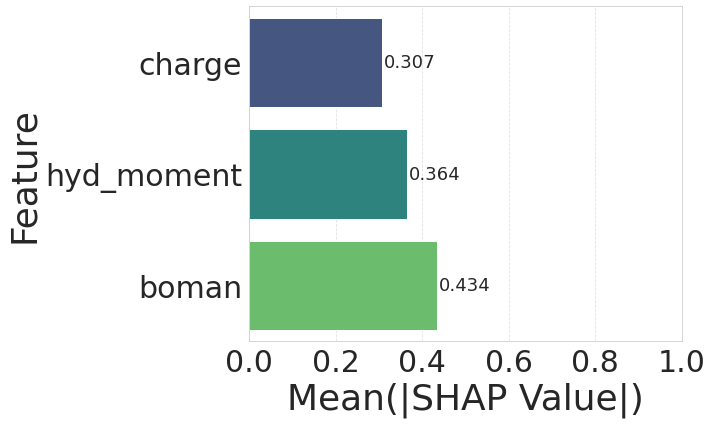

In [71]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

# New SHAP values
shap_values = {
    'boman': 0.434305,
    'hyd_moment': 0.363658,
    'charge': 0.30733
}

# Convert to DataFrame and sort
shap_df = pd.DataFrame(shap_values.items(), columns=['Feature', 'Mean SHAP Value'])
shap_df = shap_df.sort_values(by='Mean SHAP Value', ascending=True)

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(x='Mean SHAP Value', y='Feature', data=shap_df, palette='viridis')

# Titles and labels
#plt.title('Top 3 Important Features (SHAP)', fontsize=20)
plt.xlabel('Mean(|SHAP Value|)', fontsize=36)
plt.ylabel('Feature', fontsize=36)

# Tick label size
plt.xticks(fontsize=30)
plt.yticks(fontsize=30)

# Grid and layout
plt.grid(True, axis='x', linestyle='--', alpha=0.6)

# Add value labels on the bars
for i, (value, name) in enumerate(zip(shap_df['Mean SHAP Value'], shap_df['Feature'])):
    plt.text(value + 0.005, i, f'{value:.3f}', va='center', fontsize=18)

# Set x-axis limits
plt.xlim(0, 1.0)

# Grid
plt.grid(True, axis='x', linestyle='--', alpha=0.6)

plt.tight_layout()

plt.show()

In [54]:
import shap
import numpy as np
import pandas as pd

# Define feature names properly
if isinstance(X_train, pd.DataFrame):
    feature_names = X_train.columns.tolist()  # Extract feature names if X_train is a DataFrame
elif isinstance(X_train, np.ndarray):
    # Manually define feature names if using a NumPy array
    feature_names = [f'Feature_{i}' for i in range(X_train.shape[1])]

# Ensure X_train is a DataFrame with proper column names
if isinstance(X_train, np.ndarray):
    # Adjust feature_names if needed
    if len(feature_names) != X_train.shape[1]:
        feature_names = feature_names[:X_train.shape[1]]  # Adjust if too many
        feature_names.extend([f'Feature_{i}' for i in range(len(feature_names), X_train.shape[1])])  # Add if too few

    X_train = pd.DataFrame(X_train, columns=feature_names)

# Create a SHAP explainer
explainer = shap.Explainer(xgb_classifier)
shap_values = explainer(X_train)

# Get the SHAP values in a DataFrame with actual column names
shap_df = pd.DataFrame(shap_values.values, columns=feature_names)

# Calculate the mean absolute SHAP values for each feature
mean_shap_values = np.abs(shap_df).mean()

# Sort the features based on the mean absolute SHAP values
top_features = mean_shap_values.sort_values(ascending=False).head(3)

# Print the average SHAP values for the top 6 features
print("Average SHAP values for the top 6 features:")
print(top_features)

Average SHAP values for the top 6 features:
boman                 0.434305
hydrophobic_moment    0.363658
charge                0.307332
dtype: float32


In [55]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, roc_auc_score, precision_score, recall_score
from sklearn.model_selection import cross_val_score

# Create the Random Forest Classifier
rf_classifier = RandomForestClassifier(
    n_estimators=100,         # number of trees
    max_depth=2,              # adjust as needed
    random_state=42
)

# Perform 10-fold cross-validation
cv_scores = cross_val_score(rf_classifier, X_train, y_train, cv=10)

# Print the cross-validation scores
print("Cross-Validation Scores:", cv_scores)
print("Mean CV Accuracy:", cv_scores.mean())

# Fit the model on the entire training set
rf_classifier.fit(X_train, y_train)

# Predictions on the training set
y_train_pred = rf_classifier.predict(X_train)

# Calculate accuracy on the training set
train_accuracy = accuracy_score(y_train, y_train_pred)
print("Train Accuracy:", train_accuracy)

# Predictions on the test set
y_test_pred = rf_classifier.predict(X_test)

# Calculate accuracy on the test set
test_accuracy = accuracy_score(y_test, y_test_pred)
print("Test Accuracy:", test_accuracy)

# Calculate precision on the test set
precision = precision_score(y_test, y_test_pred)
print("Precision:", precision)

# Calculate sensitivity (recall) on the test set
recall = recall_score(y_test, y_test_pred)
print("Sensitivity (Recall):", recall)

# Calculate ROC AUC score on the test set
roc_auc = roc_auc_score(y_test, rf_classifier.predict_proba(X_test)[:, 1])
print("ROC AUC:", roc_auc)


Cross-Validation Scores: [0.79918033 0.79303279 0.80737705 0.75614754 0.80122951 0.75819672
 0.80327869 0.77663934 0.75359343 0.77823409]
Mean CV Accuracy: 0.7826909482613525
Train Accuracy: 0.7857728577285773
Test Accuracy: 0.7885245901639344
Precision: 0.8587570621468926
Sensitivity (Recall): 0.7136150234741784
ROC AUC: 0.8790278484831345


In [56]:
from catboost import CatBoostClassifier
from sklearn.metrics import accuracy_score, roc_auc_score, precision_score, recall_score
from sklearn.model_selection import cross_val_score

# Create the CatBoost Classifier
cat_classifier = CatBoostClassifier(
    iterations=60,       # number of boosting rounds
    learning_rate=0.1,    # step size
    depth=2,              # depth of trees
    verbose=0,            # suppress training output
    random_state=42
)

# Perform 10-fold cross-validation
cv_scores = cross_val_score(cat_classifier, X_train, y_train, cv=10)
print("Cross-Validation Scores:", cv_scores)
print("Mean CV Accuracy:", cv_scores.mean())

# Fit the model on the entire training set
cat_classifier.fit(X_train, y_train)

# Predictions on the training set
y_train_pred = cat_classifier.predict(X_train)
train_accuracy = accuracy_score(y_train, y_train_pred)
print("Train Accuracy:", train_accuracy)

# Predictions on the test set
y_test_pred = cat_classifier.predict(X_test)
test_accuracy = accuracy_score(y_test, y_test_pred)
print("Test Accuracy:", test_accuracy)

# Precision, Recall, and ROC AUC
precision = precision_score(y_test, y_test_pred)
recall = recall_score(y_test, y_test_pred)
roc_auc = roc_auc_score(y_test, cat_classifier.predict_proba(X_test)[:, 1])

print("Precision:", precision)
print("Sensitivity (Recall):", recall)
print("ROC AUC:", roc_auc)


Cross-Validation Scores: [0.87090164 0.875      0.87909836 0.84631148 0.86065574 0.84836066
 0.875      0.86270492 0.85215606 0.84804928]
Mean CV Accuracy: 0.8618238125694282
Train Accuracy: 0.8706437064370643
Test Accuracy: 0.8598360655737705
Precision: 0.8952702702702703
Sensitivity (Recall): 0.8294209702660407
ROC AUC: 0.9320151161318647


In [57]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, roc_auc_score, precision_score, recall_score
from sklearn.model_selection import cross_val_score

# Create the Decision Tree Classifier
dt_classifier = DecisionTreeClassifier(
    criterion='gini',        # or 'entropy'
    max_depth=2,             # control overfitting
    random_state=42
)

# Perform 10-fold cross-validation
cv_scores = cross_val_score(dt_classifier, X_train, y_train, cv=10)
print("Cross-Validation Scores:", cv_scores)
print("Mean CV Accuracy:", cv_scores.mean())

# Fit the model on the training set
dt_classifier.fit(X_train, y_train)

# Predictions on training set
y_train_pred = dt_classifier.predict(X_train)
train_accuracy = accuracy_score(y_train, y_train_pred)
print("Train Accuracy:", train_accuracy)

# Predictions on test set
y_test_pred = dt_classifier.predict(X_test)
test_accuracy = accuracy_score(y_test, y_test_pred)
print("Test Accuracy:", test_accuracy)

# Precision, Recall, ROC AUC
precision = precision_score(y_test, y_test_pred)
recall = recall_score(y_test, y_test_pred)
roc_auc = roc_auc_score(y_test, dt_classifier.predict_proba(X_test)[:, 1])

print("Precision:", precision)
print("Sensitivity (Recall):", recall)
print("ROC AUC:", roc_auc)


Cross-Validation Scores: [0.72336066 0.75819672 0.75204918 0.71516393 0.76639344 0.70286885
 0.75       0.73565574 0.71663244 0.72279261]
Mean CV Accuracy: 0.7343113575924867
Train Accuracy: 0.7353423534235343
Test Accuracy: 0.739344262295082
Precision: 0.7263751763046544
Sensitivity (Recall): 0.8059467918622848
ROC AUC: 0.7913289644156773


In [58]:
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, roc_auc_score, precision_score, recall_score
from sklearn.model_selection import cross_val_score

# Create the Naive Bayes Classifier
nb_classifier = GaussianNB()

# Perform 10-fold cross-validation
cv_scores = cross_val_score(nb_classifier, X_train, y_train, cv=10)
print("Cross-Validation Scores:", cv_scores)
print("Mean CV Accuracy:", cv_scores.mean())

# Fit the model on the entire training set
nb_classifier.fit(X_train, y_train)

# Predictions on the training set
y_train_pred = nb_classifier.predict(X_train)
train_accuracy = accuracy_score(y_train, y_train_pred)
print("Train Accuracy:", train_accuracy)

# Predictions on the test set
y_test_pred = nb_classifier.predict(X_test)
test_accuracy = accuracy_score(y_test, y_test_pred)
print("Test Accuracy:", test_accuracy)

# Precision, Recall, ROC AUC
precision = precision_score(y_test, y_test_pred)
recall = recall_score(y_test, y_test_pred)
roc_auc = roc_auc_score(y_test, nb_classifier.predict_proba(X_test)[:, 1])

print("Precision:", precision)
print("Sensitivity (Recall):", recall)
print("ROC AUC:", roc_auc)


Cross-Validation Scores: [0.79303279 0.79098361 0.79303279 0.75614754 0.77254098 0.75204918
 0.81352459 0.78278689 0.76180698 0.76180698]
Mean CV Accuracy: 0.7777712323694752
Train Accuracy: 0.7798277982779828
Test Accuracy: 0.7737704918032787
Precision: 0.8258527827648114
Sensitivity (Recall): 0.7198748043818466
ROC AUC: 0.8617097497973113
